# Weather prediciton

Jiahe Jiang

Date: June 4th, 2024

## Imports

In [10]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Introductions

From the initial inspection, we have the following columns:

- `Location`: The location of the weather measurement.
- `Date_Time`: The date and time of the measurement.
- `Temperature_C`: The temperature in Celsius.
- `Humidity_pct`: The humidity percentage.
- `Precipitation_mm`: The precipitation in millimeters.
- `Wind_Speed_kmh`: The wind speed in kilometers per hour.

## Load and inspect the dataset.

In [12]:
weather = pd.read_csv('data/weather_data.csv', delimiter=',')

weather.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622


## Exploratory Data Analysis (EDA) 
> Understand the data distribution and relationships.

In [21]:
weather.shape

(1000000, 6)

In [17]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Location          1000000 non-null  object 
 1   Date_Time         1000000 non-null  object 
 2   Temperature_C     1000000 non-null  float64
 3   Humidity_pct      1000000 non-null  float64
 4   Precipitation_mm  1000000 non-null  float64
 5   Wind_Speed_kmh    1000000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 45.8+ MB


In [16]:
weather.describe()

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,14.779705,60.021830,5.109639,14.997598
std,14.482558,17.324022,2.947997,8.663556
min,-19.969311,30.000009,0.000009,0.000051
25%,2.269631,45.008500,2.580694,7.490101
50%,14.778002,60.018708,5.109917,14.993777
75%,27.270489,75.043818,7.613750,22.514110
max,39.999801,89.999977,14.971583,29.999973


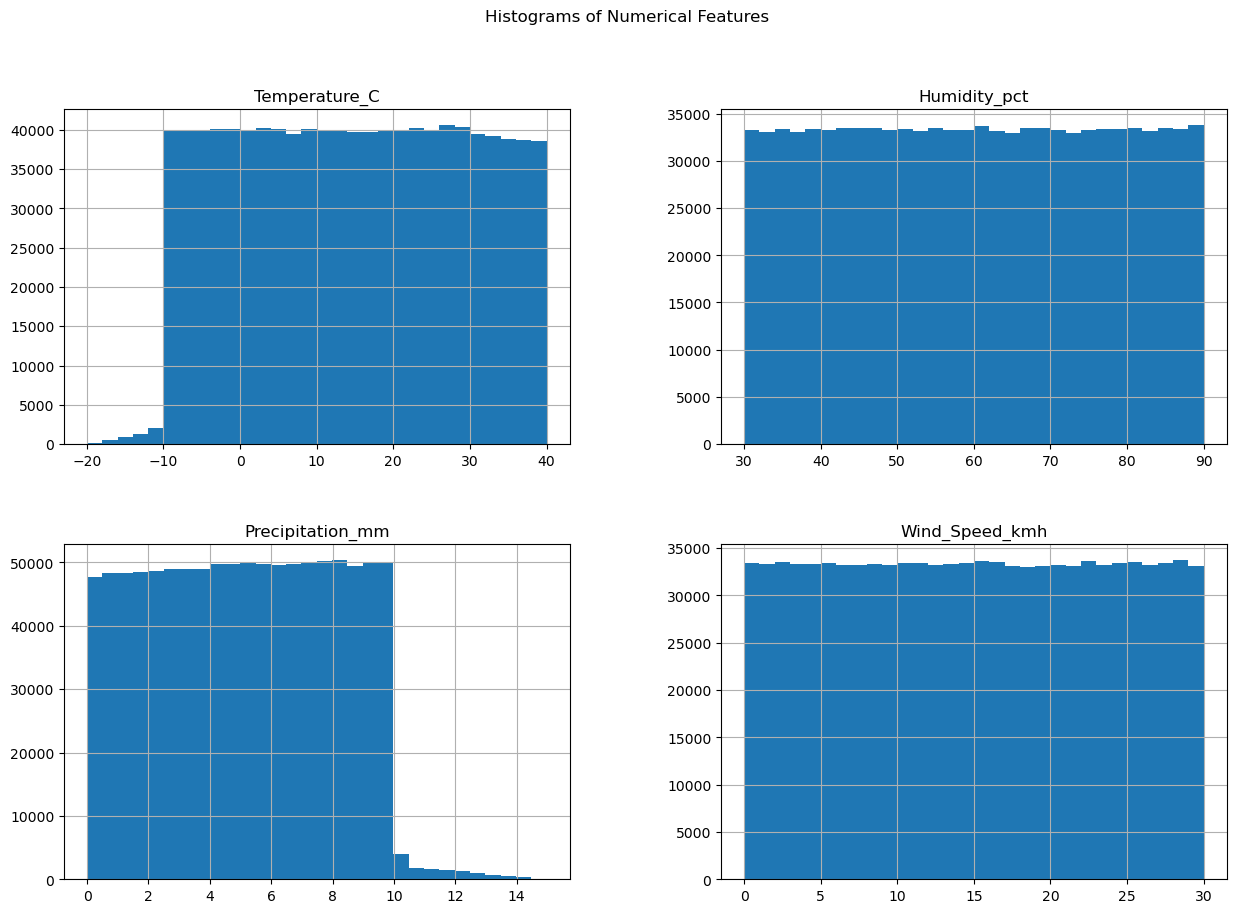

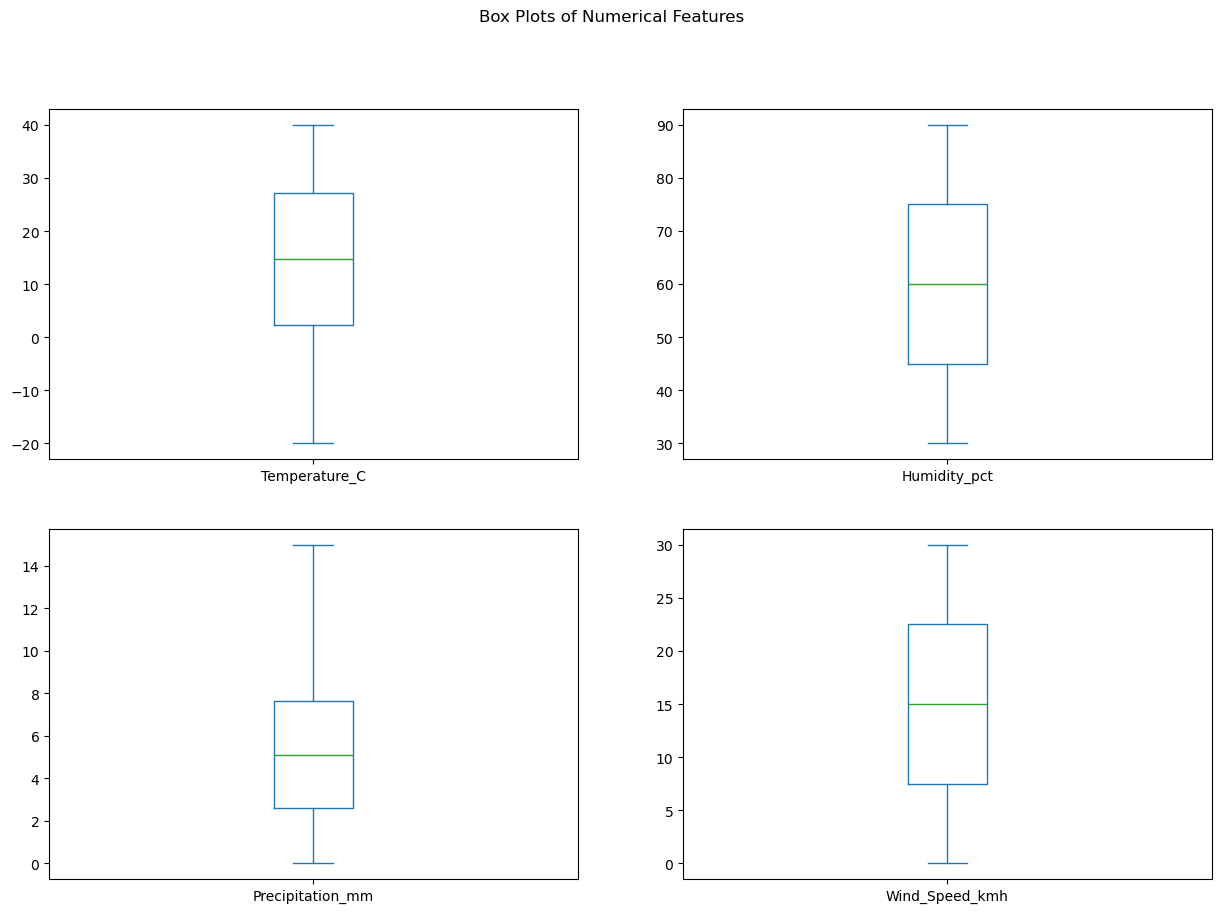

In [24]:
# Plot histograms
weather.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Plot box plots
weather[['Temperature_C', 'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh']].plot(kind='box', subplots=True, layout=(2, 2), figsize=(15, 10))
plt.suptitle('Box Plots of Numerical Features')
plt.show()

## Feature Engineering

## Preprocess the data

In [22]:
# Check for missing values
missing_values = weather.isnull().sum()
missing_values

Location            0
Date_Time           0
Temperature_C       0
Humidity_pct        0
Precipitation_mm    0
Wind_Speed_kmh      0
dtype: int64

In [31]:
# Convert 'Date_Time' to datetime
weather["Date_Time"] = pd.to_datetime(weather["Date_Time"])

# Extract datetime features
weather['Year'] = weather['Date_Time'].dt.year
weather['Month'] = weather['Date_Time'].dt.month
weather['Day'] = weather['Date_Time'].dt.day
weather['Hour'] = weather['Date_Time'].dt.hour

weather.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Year,Month,Day,Hour
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540,2024,1,14,21
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161,2024,5,17,15
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951,2024,5,11,9
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303,2024,2,26,17
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622,2024,4,29,13


In [46]:
weather["Location"].unique()

array(['San Diego', 'Philadelphia', 'San Antonio', 'San Jose', 'New York',
       'Houston', 'Dallas', 'Chicago', 'Los Angeles', 'Phoenix'],
      dtype=object)

In [32]:
drop_features = ["Date_Time", "Day", "Hour"]
categorical_features = ["Location"]
passthrough_features = ["Humidity_pct","Precipitation_mm","Wind_Speed_kmh","Year","Month"]

In [36]:
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    ("passthrough", passthrough_features),
    (categorical_transformer, categorical_features),
)

## Split the data into training and testing sets.

In [38]:
train_df, test_df = train_test_split(weather, test_size=0.10, random_state=123)

In [39]:
X_train = train_df.drop(columns=["Temperature_C"])
y_train = train_df["Temperature_C"]

X_test = test_df.drop(columns=["Temperature_C"])
y_test = test_df["Temperature_C"]

In [42]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'passthrough': FunctionTransformer(accept_sparse=True, check_inverse=False,
                     feature_names_out='one-to-one'),
 'pipeline': Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))])}

In [44]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    passthrough_features + ohe_columns
)

In [45]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc

,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Year,Month,Location_Chicago,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose
267809,39.290771,5.215298,11.197789,2024.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
274370,60.881470,9.239675,27.895051,2024.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
120167,59.981382,6.378421,6.849208,2024.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
568479,65.622903,7.584318,25.264937,2024.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
979194,43.483910,0.121448,5.501158,2024.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,69.213180,3.265939,15.891991,2024.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17730,50.344610,5.596098,9.938645,2024.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28030,33.751726,5.831077,11.120886,2024.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277869,30.840277,1.376490,15.577100,2024.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Select and train machine learning models.

## Evaluate the models

## Hyperparameter optimization 

## Interpret the results and make conclusions.